# Analysis of admixfrog for allentoft et al
Ran admixfrog on all samples with no flags in allentoft et al; here I explore results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotnine import *
import sys
sys.path.append("../src/")
from src import legend_kwargs

def filter_output(df):    
    # Filter to remove the state annotations
    df = df.loc[df["type"] != "state"]
    # Remove any archaic calls that are shorter than 0.05 cM
    min_len = .05
    df = df.drop(df.loc[((df['map_len']  < min_len) & (df['target'] != 'AFR'))].index)
    return df

def plot_introgression(sample, suffix = "", drop_afr=False):
    # Read in and filter sample data
    df = pd.read_csv(f"../processed-data/admixfrog-allentoft/{sample}/{sample}.rle.xz")
    df = filter_output(df)
    # Read in chromosome length information df
    # NOTE: chromosome lengths are taken from https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&chromInfoPage=
    chromosomes = pd.read_csv("../src/chrom_lens.csv", index_col=0)
    chromosomes.drop(['X', 'Y'], inplace=True)
    chromosomes.reset_index(inplace=True)
    chromosomes["chrom"] = chromosomes["chrom"].astype(int)
    chromosomes['x'] = 0

    # color map for plotting
    colormap = {
        'AFR' : "darkgrey", 
        # 'AFR' : "lightgrey", 
        'NEA' : "c", 
        'DEN' : "y", 
        'AFRNEA' : "magenta", 
        'AFRDEN' : "lime", 
        'NEADEN' : "orange",
    }
    if drop_afr:
        # Skip plotting AFR ancestry
        df = df[df['target'] != "AFR"]
    p1 = (
        ggplot()
        + geom_segment(
            aes(x='x', xend='length', y='chrom', yend='chrom'), 
            data=chromosomes, 
            color='grey', alpha=.2, size=5)
        + geom_segment(
            aes(x='pos', xend='pos_end', y='chrom', yend='chrom', color='target'), 
            size=5, 
            data=df)
        + scale_color_manual(values=colormap, na_value='grey')
        + scale_y_continuous(breaks=range(1, 23))
        + labs(x="Position [bp]", y="Chromosome", color="Ancestry", title=sample + suffix)
        + theme_bw()
        + theme(panel_grid_major=element_blank(),  # Remove major gridlines
                panel_grid_minor=element_blank(),
                panel_border=element_blank())
    )
    p1.show()

# Read sample metadata
metadata = pd.read_csv("../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)
# Get chromosome lengths
chromosomes = pd.read_csv("../src/chrom_lens.csv", index_col=0)
chromosomes.drop(['X', 'Y'], inplace=True)
chromosomes.reset_index(inplace=True)
chromosomes["chrom"] = chromosomes["chrom"].astype(int)
# Get sample info
samples = pd.read_csv("../processed-data/noflag.inds.txt", header=None, index_col=0)
samples = samples.index.tolist()

In [2]:
# plot_introgression("NEO830")
# plot_introgression("NEO823")


In [3]:
metadata["Age average"].str.replace(",", "_")


Individual ID
baa01    1_909
bab01    2_041
I9133    1_970
I9028    2_103
I9134    1_199
         ...  
MA577      100
5832     7_293
A460     4_640
Nr74       100
AM71       100
Name: Age average, Length: 1664, dtype: object

In [26]:
# def spatial_ancestry(sample, anc="NEA"):
#     val

sample = "baa01"
anc = "NEA"
res_df = pd.DataFrame(columns=["Latitude", "Longitude", "Country", "Age", anc])
metadata["Age average"] = metadata["Age average"].replace(",", "_")

for sample in samples:
    try:
        res2 = pd.read_csv(f"../processed-data/admixfrog-allentoft/{sample}/{sample}.res2.xz", index_col=0)
        pct_anc = res2.loc[anc, "mean"] * 100
        res_df.loc[sample, ["Latitude", "Longitude", "Country", "Age"]] = metadata.loc[sample, ["Latitude", "Longitude", "Country", "Age average"]].values
        res_df.loc[sample, anc] = pct_anc
    except FileNotFoundError:
        pass

# res_df["Age"] = res_df["Age"].astype(int)
print("Samples read: ", res_df.shape[0])

Samples read:  136


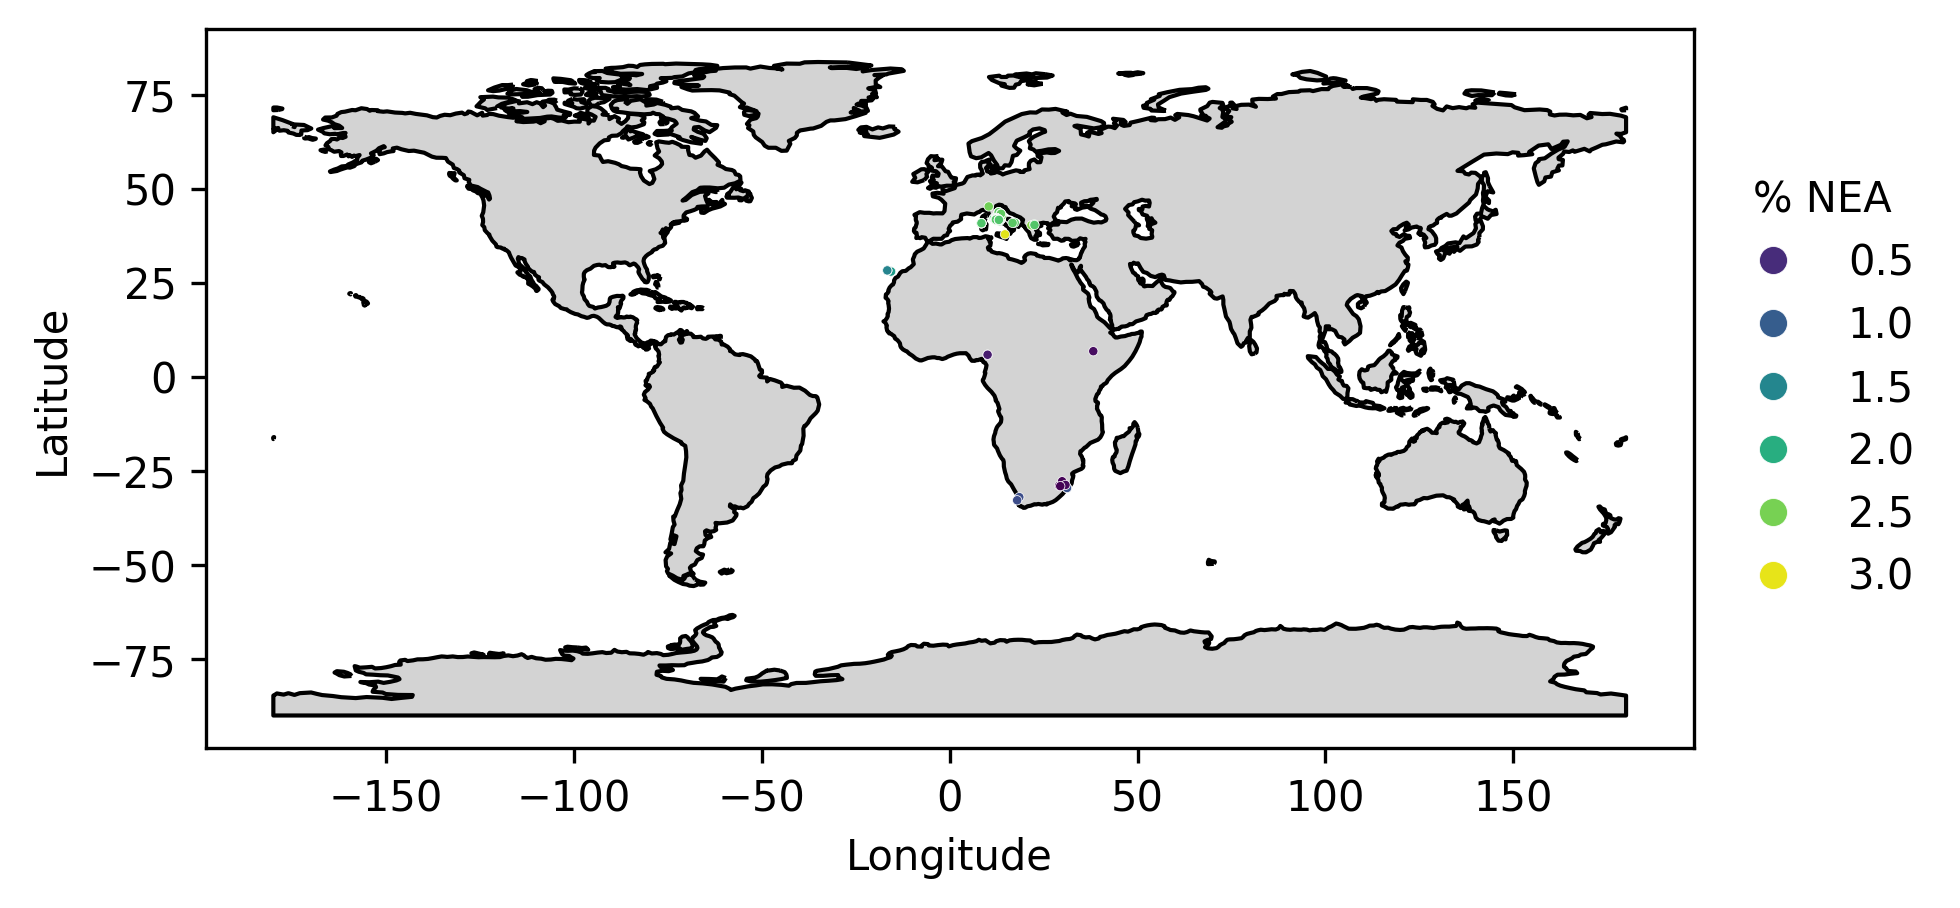

In [27]:
import geopandas as gpd
import geodatasets

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
# gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

cmap = "viridis"
# norm = plt.Normalize(res_df[anc].min(), res_df[anc].max())
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df,
    y="Latitude", x="Longitude", hue=anc,
    # edgecolor=None, 
    s=5, palette=cmap,
    ax=ax
    )

ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())
# ax.get_legend().remove()
# ax.figure.colorbar(sm)
plt.show()

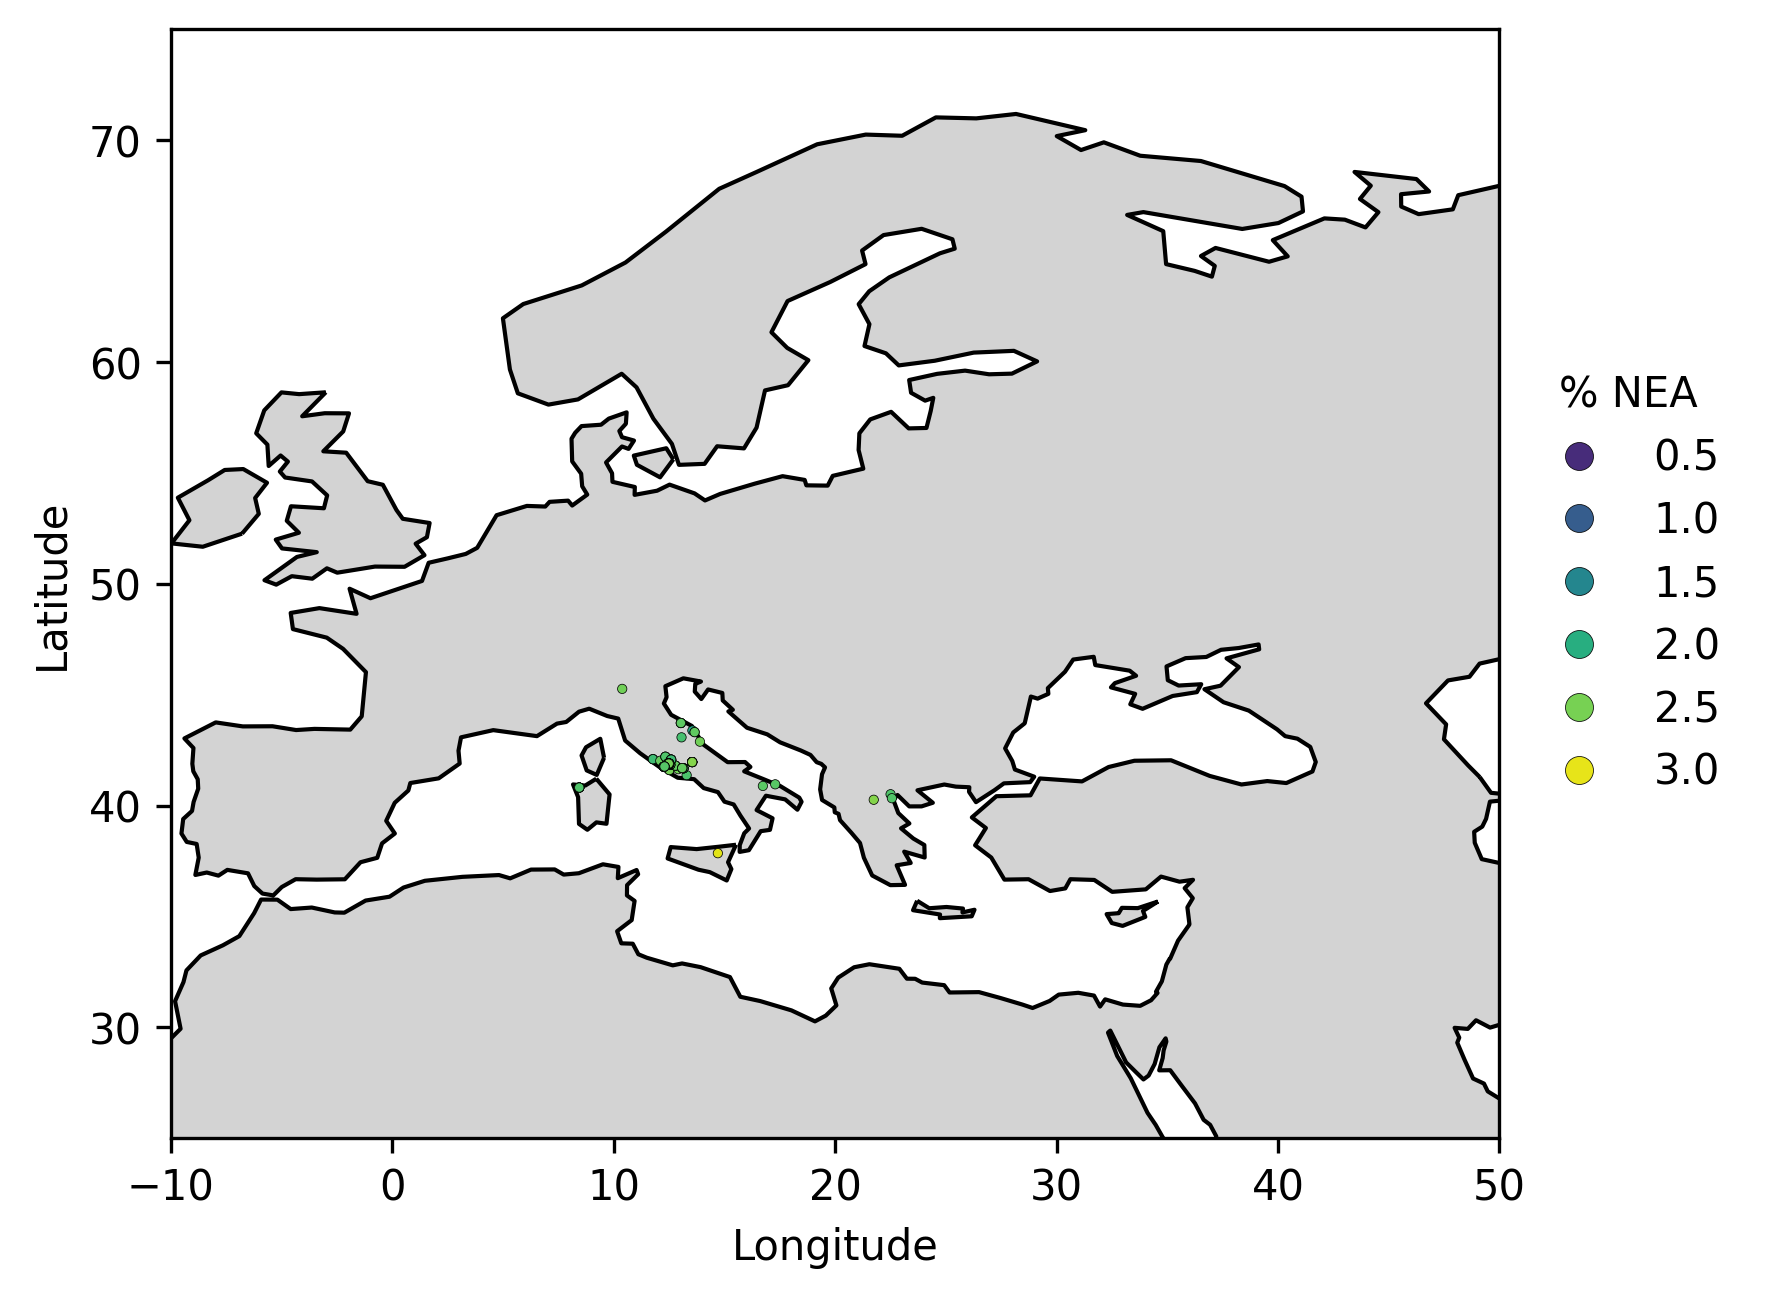

In [25]:
fig, ax = plt.subplots(dpi=300)
world.plot(
    edgecolor='k', facecolor='lightgrey',
    ax=ax,
    )

sns.scatterplot(
    res_df,
    y="Latitude", x="Longitude", hue=anc,
    edgecolor='k', 
    s=5, 
    palette=cmap,
    ax=ax
    )

ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())

ax.set_xlim(-10, 50)
ax.set_ylim(25, 75)
plt.show()

In [6]:
# fig, ax = plt.subplots(dpi=300)
# world.plot(
#     edgecolor='k', facecolor='lightgrey',
#     ax=ax,
#     )

# sns.scatterplot(
#     res_df,
#     y="Latitude", x="Longitude", hue="Age",
#     edgecolor=None, s=5, palette='viridis',
#     ax=ax
#     )


# ax.legend(markerscale=3, title=f"% {anc}",  **legend_kwargs())

# plt.show()